# Retrieving the Nth best redrock fit

This tutorial describes how to look up the Nth best redrock fit coefficients. 

See https://desi.lbl.gov/trac/wiki/Computing/JupyterAtNERSC to configure Jupyter at NERSC to be able to run this
tutorial using jupyter.nersc.gov and the fuji data in `/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/cumulative/80618/20210328/`. This notebook runs on kernel 22.2. 

The bottom of this tutorial lists the code versions used while testing this.

Raffaella Capasso<br/>
July 2022

## Basic imports

In [1]:
import os
from astropy.table import Table
import numpy as np
import desispec.io

import matplotlib.pyplot as plt
import redrock.templates
import h5py
import sys

Add the tutorials directory to the python search path so that we can import desitutorials

In [2]:
sys.path.append(os.path.abspath(os.getcwd()+'/../py/'))

import desitutorials

Move into the directory that contains the reference run data and set some environment variables so that desispec can find the files.  If you are running locally (*e.g.* on your laptop instead of at jupyter.nersc.gov, replace these with wherever you installed the reference run data.

In [3]:
os.chdir('/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/cumulative/80618/20210328/')

Import redrock templates

In [4]:
templates = dict()
for filename in redrock.templates.find_templates():
    # print('test')
    t = redrock.templates.Template(filename) #check if you can add a "verbose=False"
    templates[(t.template_type, t.sub_type)] = t


DEBUG: Reading templates from /global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/code/redrock-templates/main
INFO: rrtemplate-GALAXY-None-v2.6.fits GALAXY  PCA IGM=Calura12 z=-0.005-1.6997
INFO: rrtemplate-QSO-LOZ-v1.0.fits QSO LOZ PCA IGM=Calura12 z=0.05-1.5983
INFO: rrtemplate-QSO-HIZ-v1.1.fits QSO HIZ PCA IGM=Kamble20 z=1.4-6.993
INFO: rrtemplate-STAR-A-v0.1.fits STAR A PCA IGM=None z=-0.002-0.002
INFO: rrtemplate-STAR-B-v0.1.fits STAR B PCA IGM=None z=-0.002-0.002
INFO: rrtemplate-STAR-CV-v0.1.fits STAR CV PCA IGM=None z=-0.002-0.002
INFO: rrtemplate-STAR-F-v0.1.fits STAR F PCA IGM=None z=-0.002-0.002
INFO: rrtemplate-STAR-G-v0.1.fits STAR G PCA IGM=None z=-0.002-0.002
INFO: rrtemplate-STAR-K-v0.1.fits STAR K PCA IGM=None z=-0.002-0.002
INFO: rrtemplate-STAR-M-v0.1.fits STAR M PCA IGM=None z=-0.002-0.002
INFO: rrtemplate-STAR-WD-v0.1.fits STAR WD PCA IGM=None z=-0.002-0.002


Read in the spectra and the matching zbest file. Also read the fibermap and trim to a unique set that row-matches the zbest file.

In [5]:
zbest = Table.read('redrock-0-80618-thru20210328.fits', hdu=1).filled('')
spectra = desispec.io.read_spectra('coadd-0-80618-thru20210328.fits')

fm = Table.read('redrock-0-80618-thru20210328.fits', hdu='FIBERMAP')
ii=sorted(np.unique(fm['TARGETID'], return_index=True)[1])
assert np.all(fm['TARGETID'] == zbest['TARGETID'])
fm = fm[ii]

INFO:spectra.py:391:read_spectra: iotime 2.736 sec to read coadd-0-80618-thru20210328.fits at 2024-06-24T12:44:00.016050


In [6]:
goodELGs = (zbest['SPECTYPE'] == 'GALAXY')  
goodELGs &= (zbest['ZWARN'] == 0)  &  (zbest['DELTACHI2']>5)
goodELGs &= (fm['OBJTYPE'] == 'TGT')

In [7]:
i = np.where(goodELGs)[0][0]
z = zbest['Z'][i]
targetid = zbest['TARGETID'][i]
spectype = zbest['SPECTYPE'][i].strip()
subtype = zbest['SUBTYPE'][i].strip()
fulltype = (spectype, subtype)
ncoeff = templates[fulltype].flux.shape[0]
coeff = zbest['COEFF'][i][0:ncoeff]

tflux = templates[fulltype].flux.T.dot(coeff)
twave = templates[fulltype].wave * (1+z)



In [8]:
print(z,targetid)

0.3149693869731157 39633023964023416


(-1.0, 8.0)

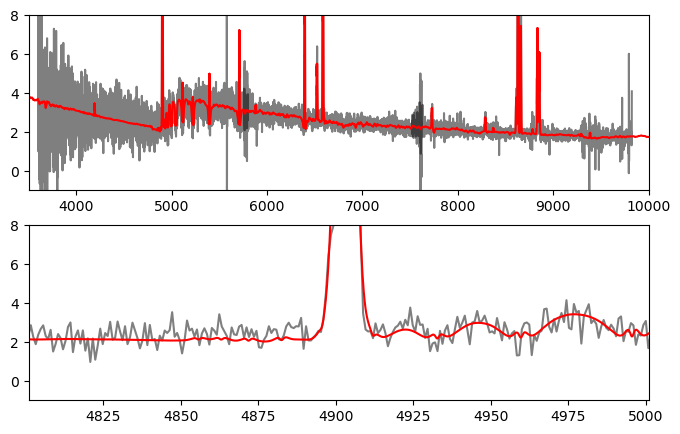

In [9]:
ispec = np.where(spectra.fibermap['TARGETID'] == targetid)[0][0]

plt.figure(figsize=(8,5))
plt.subplot(211)
maxflux = 0.0
for band in spectra.bands:
    plt.plot(spectra.wave[band], spectra.flux[band][ispec], 'k-', alpha=0.5)
    maxflux = max(maxflux, np.max(spectra.flux[band][ispec]))

plt.plot(twave, tflux, 'r-')
plt.xlim(3500, 10000)
# ylim(-1, 0.9*maxflux)
plt.ylim(-1, 8)

#- zoom in on [OII]
plt.subplot(212)
for band in spectra.bands:
    plt.plot(spectra.wave[band], spectra.flux[band][ispec], 'k-', alpha=0.5)

plt.plot(twave, tflux, 'r-')
plt.xlim(3727*(1+z)-100, 3727*(1+z)+100)
plt.ylim(-1,8)

## Look at the best 2nd fit

In [10]:
filename = 'rrdetails-0-80618-thru20210328.h5'

data = h5py.File(filename, mode='r')
zfit = Table(np.array(data['zfit'][str(targetid)]['zfit']))
zfit['znum', 'z', 'spectype', 'zwarn', 'chi2', 'deltachi2']

znum,z,spectype,zwarn,chi2,deltachi2
int64,float64,bytes6,int64,float64,float64
0,0.3149693869731157,GALAXY,0,19333.786024093628,38410.538469314575
1,1.3150506971144742,GALAXY,0,57744.3244934082,4437.5872802734375
2,0.31481525204501165,QSO,0,62181.91177368164,19377.313468933105
3,0.7235722752431557,GALAXY,0,81559.22524261475,33740.0152888298
4,1.314497913113018,QSO,0,115299.24053144455,3688.5156153440475
5,2.0833853072073962,QSO,0,118987.7561467886,3765.731163650271
6,0.0006783307173301325,STAR,4,122753.48731043887,0.0
7,0.0002135949752383098,STAR,4,123044.96887801004,0.0
8,0.0007834616335719919,STAR,4,123931.01773693066,0.0


In [11]:
coeff_best=zfit['coeff'][0]
coeff_2nd=zfit['coeff'][1]
z_best=zfit['z'][0]
z_2nd=zfit['z'][1]

targetids = np.array(data['targetids'])
z_table = np.array(data['zscan']['GALAXY']['redshifts']) #scanned z
zchi2 = np.array(data['zscan']['GALAXY']['zchi2']) #500 targets per z
chi2_penalty = np.array(data['zscan']['GALAXY']['penalty'])

tflux_best = templates[fulltype].flux.T.dot(coeff_best)
twave_best = templates[fulltype].wave * (1+z_best)

tflux_2nd = templates[fulltype].flux.T.dot(coeff_2nd)
twave_2nd = templates[fulltype].wave * (1+z_2nd)

(-1.0, 8.0)

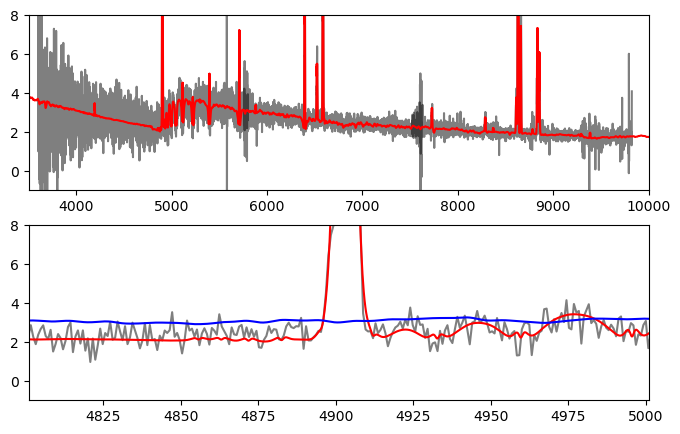

In [12]:
plt.figure(figsize=(8,5))

ymin=-1.
ymax=8.

plt.subplot(211)

for band in spectra.bands:
    plt.plot(spectra.wave[band], spectra.flux[band][ispec], 'k-', alpha=0.5)

# plot(wave, flux, 'k-', alpha=0.5)
plt.plot(twave, tflux, 'r-')
plt.xlim(3500, 10000)
plt.ylim(ymin, ymax)


#- zoom in on [OII]
plt.subplot(212)
for band in spectra.bands:
    plt.plot(spectra.wave[band], spectra.flux[band][ispec], 'k-', alpha=0.5)

# plot(wave, flux, 'k-', alpha=0.5)
plt.plot(twave_best, tflux_best, 'r-')
plt.plot(twave_2nd, tflux_2nd, 'b-')
plt.xlim(3727*(1+z)-100, 3727*(1+z)+100)
plt.ylim(ymin, ymax)

## Code versions

In [13]:
print('Code versions used for this tutorial:')
desitutorials.print_code_versions()

Code versions used for this tutorial:
python      : 3.10.14
numpy       : 1.22.4
scipy       : 1.8.1
astropy     : 6.0.1
yaml        : 6.0.1
matplotlib  : 3.8.4
fitsio      : 1.2.1
h5py        : 3.11.0
desiutil    : 3.4.3.dev1103
desispec    : 0.63.6.dev8567
desitarget  : 2.7.0.dev5481
redrock     : 0.20.1.dev1051
speclite    : 
